In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from haversine import haversine, Unit, haversine_vector
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import os
from dotenv import load_dotenv
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import lnglat_to_meters
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.structure import StructureModel
from sklearn.model_selection import train_test_split
import networkx as nx

In [2]:
# Path to the CSV file
file_path = '/home/moraa/Documents/10_academy/Week-8/artifacts/df_merged.csv'

# Load the CSV file into a DataFrame
df_merged = pd.read_csv(file_path)

# Display the first few rows of the loaded DataFrame to verify
print(df_merged.head())

   id  Trip ID  driver_id driver_action       lat       lng  \
0  17   392005     171165      rejected  0.467252 -0.165609   
1  18   392005     243172      rejected  0.573114  0.332253   
2  19   392005     244078      rejected  0.686601 -0.144470   
3  21   392005     243392      rejected  0.502039 -0.232383   
4  23   392005     171165      rejected  0.467252 -0.165609   

                   Trip Origin             Trip Destination  \
0  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
1  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
2  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
3  6.565087699999999,3.3844415  6.499696300000001,3.3509075   
4  6.565087699999999,3.3844415  6.499696300000001,3.3509075   

       Trip Start Time        Trip End Time  ... Trip Duration Category  \
0  2021-07-01 10:53:36  2021-07-01 11:27:51  ...                  Short   
1  2021-07-01 10:53:36  2021-07-01 11:27:51  ...                  Short   
2  2021-07-01 10:

Converting non-numerical values to numerical

In [3]:
df_merged.dtypes

id                                       int64
Trip ID                                  int64
driver_id                                int64
driver_action                           object
lat                                    float64
lng                                    float64
Trip Origin                             object
Trip Destination                        object
Trip Start Time                         object
Trip End Time                           object
Day of Week                             object
Hour                                     int64
Time of Day                             object
Is Holiday                                bool
Origin Lat                             float64
Origin Lng                             float64
Destination Lat                        float64
Destination Lng                        float64
Start Hour                               int64
Start Day of Week                        int64
Trip Duration                          float64
Driver Distan

In [4]:
# List all non-numerical columns
non_numerical_columns = df_merged.select_dtypes(exclude=['number']).columns.tolist()

print("Non-numerical columns:")
print(non_numerical_columns)

Non-numerical columns:
['driver_action', 'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time', 'Day of Week', 'Time of Day', 'Is Holiday', 'Previous Trip End Time', 'Trip Duration Category', 'Origin-Destination']


In [5]:
df_merged[['Previous Trip End Time', 'Trip Duration Category', 'Origin-Destination']].head()

,Previous Trip End Time,Trip Duration Category,Origin-Destination
0,2021-07-01 11:27:51,Short,"6.565087699999999,3.3844415 to 6.4996963000000..."
1,2021-07-01 11:27:51,Short,"6.565087699999999,3.3844415 to 6.4996963000000..."
2,2021-07-01 11:27:51,Short,"6.565087699999999,3.3844415 to 6.4996963000000..."
3,2021-07-01 11:27:51,Short,"6.565087699999999,3.3844415 to 6.4996963000000..."
4,2021-07-01 11:27:51,Short,"6.565087699999999,3.3844415 to 6.4996963000000..."


In [6]:
df_merged['Trip Duration Category'].unique()

array(['Short'], dtype=object)

In [7]:
df_merged.head()

,id,Trip ID,driver_id,driver_action,lat,lng,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,...,Trip Duration Category,Origin-Destination,Origin-Destination Count,Origin Distance to City Center,Destination Distance to City Center,Acceptance Rate,Driver Experience,Avg Trip Distance,Avg Trip Duration,Avg Speed
0,17,392005,171165,rejected,0.467252,-0.165609,"6.565087699999999,3.3844415","6.499696300000001,3.3509075",2021-07-01 10:53:36,2021-07-01 11:27:51,...,Short,"6.565087699999999,3.3844415 to 6.4996963000000...",51,54.83083,73.36347,0.000875,5715,-0.027184,0.026039,197344.050231
1,18,392005,243172,rejected,0.573114,0.332253,"6.565087699999999,3.3844415","6.499696300000001,3.3509075",2021-07-01 10:53:36,2021-07-01 11:27:51,...,Short,"6.565087699999999,3.3844415 to 6.4996963000000...",51,54.83083,73.36347,0.051209,703,0.162084,0.035407,255134.934336
2,19,392005,244078,rejected,0.686601,-0.144470,"6.565087699999999,3.3844415","6.499696300000001,3.3509075",2021-07-01 10:53:36,2021-07-01 11:27:51,...,Short,"6.565087699999999,3.3844415 to 6.4996963000000...",51,54.83083,73.36347,0.010111,3066,-0.111655,-0.082415,199564.036556
3,21,392005,243392,rejected,0.502039,-0.232383,"6.565087699999999,3.3844415","6.499696300000001,3.3509075",2021-07-01 10:53:36,2021-07-01 11:27:51,...,Short,"6.565087699999999,3.3844415 to 6.4996963000000...",51,54.83083,73.36347,0.007194,3475,-0.076518,0.012019,192644.565309
4,23,392005,171165,rejected,0.467252,-0.165609,"6.565087699999999,3.3844415","6.499696300000001,3.3509075",2021-07-01 10:53:36,2021-07-01 11:27:51,...,Short,"6.565087699999999,3.3844415 to 6.4996963000000...",51,54.83083,73.36347,0.000875,5715,-0.027184,0.026039,197344.050231


Encoding

In [8]:
# 1. Transform 'driver_action' column using LabelEncoder and retain the original column
label_encoder_action = LabelEncoder()
df_merged['driver_action_encoded'] = label_encoder_action.fit_transform(df_merged['driver_action'])

# 2. 'Trip Origin' and 'Trip Destination' columns remain unchanged

# 3. Convert 'Trip Start Time' and 'Trip End Time' to datetime if needed
df_merged['Trip Start Time'] = pd.to_datetime(df_merged['Trip Start Time'])
df_merged['Trip End Time'] = pd.to_datetime(df_merged['Trip End Time'])

# 4. Transform 'Day of Week' column
day_mapping = {
    'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4,
    'Thursday': 5, 'Friday': 6, 'Saturday': 7
}
df_merged['Day of Week Encoded'] = df_merged['Day of Week'].map(day_mapping)

# 5. Transform 'Time of Day' column using LabelEncoder
encoder = LabelEncoder()
df_merged['Time of Day Encoded'] = encoder.fit_transform(df_merged['Time of Day'])

# 6. Transform 'Is Holiday' column (assuming it's boolean)
df_merged['Is Holiday'] = df_merged['Is Holiday'].astype(int)

# 7. Convert 'Previous Trip End Time' to useful time components
df_merged['Previous Trip End Time'] = pd.to_datetime(df_merged['Previous Trip End Time'])
df_merged['Previous Trip End Hour'] = df_merged['Previous Trip End Time'].dt.hour
df_merged['Previous Trip End Day of Week'] = df_merged['Previous Trip End Time'].dt.dayofweek
df_merged['Previous Trip End Month'] = df_merged['Previous Trip End Time'].dt.month

# 8. Label Encoding for 'Trip Duration Category'
label_encoder_duration = LabelEncoder()
df_merged['Trip Duration Category Encoded'] = label_encoder_duration.fit_transform(df_merged['Trip Duration Category'])

# 9. Frequency Encoding for 'Origin-Destination'
origin_destination_counts = df_merged['Origin-Destination'].value_counts().to_dict()
df_merged['Origin-Destination Encoded'] = df_merged['Origin-Destination'].map(origin_destination_counts)

# 10. Drop original non-numerical columns if they are no longer needed
original_non_numerical_columns = ['driver_action', 'Trip Origin', 'Trip Destination', 'Trip Start Time', 
                                  'Trip End Time', 'Day of Week', 'Time of Day', 'Is Holiday', 
                                  'Previous Trip End Time', 'Trip Duration Category', 'Origin-Destination']
df_merged = df_merged.drop(columns=original_non_numerical_columns)

# Display the DataFrame to verify the changes
df_merged.head()

,id,Trip ID,driver_id,lat,lng,Hour,Origin Lat,Origin Lng,Destination Lat,Destination Lng,...,Avg Trip Duration,Avg Speed,driver_action_encoded,Day of Week Encoded,Time of Day Encoded,Previous Trip End Hour,Previous Trip End Day of Week,Previous Trip End Month,Trip Duration Category Encoded,Origin-Destination Encoded
0,17,392005,171165,0.467252,-0.165609,10,0.48886,0.082547,-0.497597,-0.435928,...,0.026039,197344.050231,1,5,2,11,3,7,0,33
1,18,392005,243172,0.573114,0.332253,10,0.48886,0.082547,-0.497597,-0.435928,...,0.035407,255134.934336,1,5,2,11,3,7,0,33
2,19,392005,244078,0.686601,-0.144470,10,0.48886,0.082547,-0.497597,-0.435928,...,-0.082415,199564.036556,1,5,2,11,3,7,0,33
3,21,392005,243392,0.502039,-0.232383,10,0.48886,0.082547,-0.497597,-0.435928,...,0.012019,192644.565309,1,5,2,11,3,7,0,33
4,23,392005,171165,0.467252,-0.165609,10,0.48886,0.082547,-0.497597,-0.435928,...,0.026039,197344.050231,1,5,2,11,3,7,0,33


In [9]:
df_merged.dtypes

id                                       int64
Trip ID                                  int64
driver_id                                int64
lat                                    float64
lng                                    float64
Hour                                     int64
Origin Lat                             float64
Origin Lng                             float64
Destination Lat                        float64
Destination Lng                        float64
Start Hour                               int64
Start Day of Week                        int64
Trip Duration                          float64
Driver Distance to Origin              float64
Trip Distance                          float64
Geodesic Distance                      float64
Haversine Distance                     float64
Average Speed                          float64
Time Since Last Trip                   float64
Origin-Destination Count                 int64
Origin Distance to City Center         float64
Destination D

# Split data into training and hold-out set

In [10]:
# Set the number of rows you want in your subset
subset_size = 100000  # Adjust this based on your computational resources

# Randomly sample from the DataFrame
df_merged = df_merged.sample(n=subset_size, random_state=1)

In [11]:
# Function to replace spaces with underscores in column names
def replace_spaces_with_underscores(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

# Applying the function to your DataFrame
df_merged = replace_spaces_with_underscores(df_merged)

df_merged

,id,Trip_ID,driver_id,lat,lng,Hour,Origin_Lat,Origin_Lng,Destination_Lat,Destination_Lng,...,Avg_Trip_Duration,Avg_Speed,driver_action_encoded,Day_of_Week_Encoded,Time_of_Day_Encoded,Previous_Trip_End_Hour,Previous_Trip_End_Day_of_Week,Previous_Trip_End_Month,Trip_Duration_Category_Encoded,Origin-Destination_Encoded
1463881,1466875,442023,203428,0.362433,-0.333394,12,0.587361,-0.681704,-0.228941,-0.031476,...,0.034960,198263.575368,1,6,0,10,4,7,0,184
1444046,1447037,440728,243975,1.008687,-0.732244,19,1.087114,-0.530791,-1.243271,0.340196,...,-0.236107,237280.819810,1,5,1,19,3,7,0,30
221230,222638,401046,244243,-0.412813,-0.498520,13,-0.491426,-0.566865,-0.473857,-0.573881,...,0.023077,205086.908470,1,6,0,13,4,7,0,452
516689,518296,411965,243408,1.130605,-0.073587,7,1.087437,-0.409999,-1.007789,-0.903048,...,-0.000543,201745.537720,1,1,2,20,5,7,0,25
47266,48209,394286,244055,0.139605,-0.289206,12,-0.005718,-0.532149,0.436981,-1.383460,...,0.021875,193287.168109,1,5,0,13,3,7,0,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516024,1519183,446219,226949,0.277372,-1.419891,15,0.266265,-1.016004,1.139894,-0.008774,...,0.036932,202803.130052,1,6,0,16,4,7,0,22
1506330,1509489,445433,243826,0.082766,-0.380708,14,-0.238153,-0.229283,0.738617,-0.688725,...,0.002812,195704.005134,1,6,0,15,4,7,0,42
1196025,1198607,430140,245506,1.008105,-0.732313,12,0.994979,-0.741266,0.952292,-0.404962,...,0.035218,257610.808301,1,4,0,14,2,7,0,50
30979,31866,393583,244274,1.007093,-0.731297,11,1.119722,-0.527326,1.075968,-0.553153,...,-0.009646,224996.313548,1,5,2,12,3,7,0,193


In [12]:
# Separate predictors (X) and target variable (y)
X = df_merged.drop(columns=['driver_action_encoded'])
y = df_merged['driver_action_encoded']

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (80000, 34)
y_train shape: (80000,)
X_test shape: (20000, 34)
y_test shape: (20000,)


In [13]:
X_train.isnull().sum()

id                                     0
Trip_ID                                0
driver_id                              0
lat                                    0
lng                                    0
Hour                                   0
Origin_Lat                             0
Origin_Lng                             0
Destination_Lat                        0
Destination_Lng                        0
Start_Hour                             0
Start_Day_of_Week                      0
Trip_Duration                          0
Driver_Distance_to_Origin              0
Trip_Distance                          0
Geodesic_Distance                      0
Haversine_Distance                     0
Average_Speed                          0
Time_Since_Last_Trip                   0
Origin-Destination_Count               0
Origin_Distance_to_City_Center         0
Destination_Distance_to_City_Center    0
Acceptance_Rate                        0
Driver_Experience                      0
Avg_Trip_Distanc

In [14]:
X_train.dtypes

id                                       int64
Trip_ID                                  int64
driver_id                                int64
lat                                    float64
lng                                    float64
Hour                                     int64
Origin_Lat                             float64
Origin_Lng                             float64
Destination_Lat                        float64
Destination_Lng                        float64
Start_Hour                               int64
Start_Day_of_Week                        int64
Trip_Duration                          float64
Driver_Distance_to_Origin              float64
Trip_Distance                          float64
Geodesic_Distance                      float64
Haversine_Distance                     float64
Average_Speed                          float64
Time_Since_Last_Trip                   float64
Origin-Destination_Count                 int64
Origin_Distance_to_City_Center         float64
Destination_D

In [15]:
import pandas as pd
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure
import matplotlib.pyplot as plt

# Assuming X_train is your training dataset
# Optionally, use a subset for initial analysis due to large size
df_subset = X_train.sample(n=10000, random_state=42)  # Adjust sample size as necessary

# Learn the structure of the Bayesian Network using the NOTEARS algorithm
sm = from_pandas(df_subset, tabu_edges=[])

# Plot the structure of the Bayesian Network
plt.figure(figsize=(15, 10))  # Adjust figure size as needed
plot_structure(sm)
plt.show()

# Print the learned causal graph relationships
print("Learned Causal Graph:")
for edge in sm.edges:
    print(edge)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Conside

<Figure size 1500x1000 with 0 Axes>

Learned Causal Graph:
('id', 'Trip_ID')
('id', 'driver_id')
('id', 'lat')
('id', 'lng')
('id', 'Hour')
('id', 'Origin_Lat')
('id', 'Origin_Lng')
('id', 'Destination_Lat')
('id', 'Destination_Lng')
('id', 'Start_Hour')
('id', 'Start_Day_of_Week')
('id', 'Trip_Duration')
('id', 'Driver_Distance_to_Origin')
('id', 'Trip_Distance')
('id', 'Geodesic_Distance')
('id', 'Haversine_Distance')
('id', 'Average_Speed')
('id', 'Time_Since_Last_Trip')
('id', 'Origin-Destination_Count')
('id', 'Origin_Distance_to_City_Center')
('id', 'Destination_Distance_to_City_Center')
('id', 'Acceptance_Rate')
('id', 'Driver_Experience')
('id', 'Avg_Trip_Distance')
('id', 'Avg_Trip_Duration')
('id', 'Avg_Speed')
('id', 'Day_of_Week_Encoded')
('id', 'Time_of_Day_Encoded')
('id', 'Previous_Trip_End_Hour')
('id', 'Previous_Trip_End_Day_of_Week')
('id', 'Previous_Trip_End_Month')
('id', 'Origin-Destination_Encoded')
('Trip_ID', 'id')
('Trip_ID', 'driver_id')
('Trip_ID', 'lat')
('Trip_ID', 'lng')
('Trip_ID', 'Hour')
(

/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Conside

Figure(1500x1000)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")


Figure(1500x1000)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in 

Figure(1500x1000)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Conside

Figure(1500x1000)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Conside

Figure(1500x1000)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Conside

Figure(1500x1000)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")


Figure(1500x1000)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Conside

Figure(1500x1000)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in double_scalars
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalne

Figure(1500x1000)


/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in double_scalars
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalne

Figure(1500x1000)
Jaccard Similarity Scores:
10% of data: Jaccard Similarity Index = 1.0000
20% of data: Jaccard Similarity Index = 1.0000
30% of data: Jaccard Similarity Index = 1.0000
40% of data: Jaccard Similarity Index = 1.0000
50% of data: Jaccard Similarity Index = 1.0000
60% of data: Jaccard Similarity Index = 1.0000
70% of data: Jaccard Similarity Index = 1.0000
80% of data: Jaccard Similarity Index = 1.0000
90% of data: Jaccard Similarity Index = 1.0000
100% of data: Jaccard Similarity Index = 1.0000


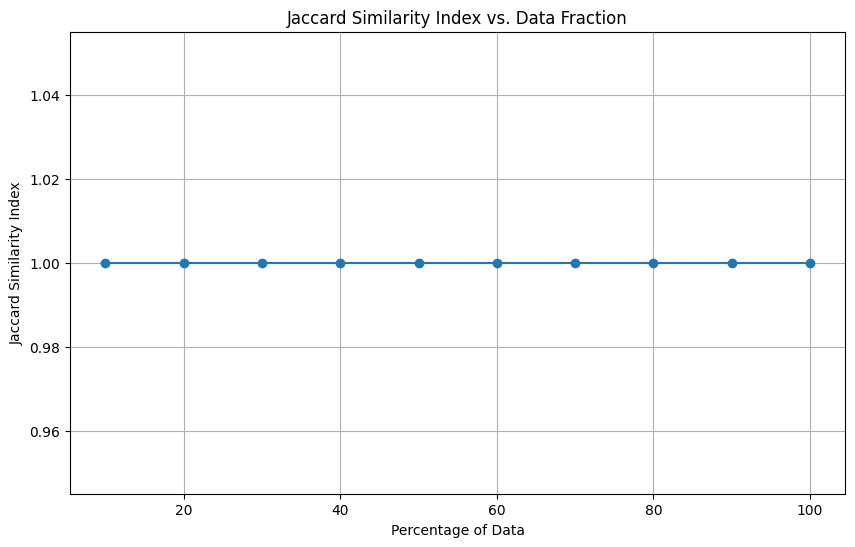

In [16]:
import pandas as pd
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# Function to compute Jaccard Similarity Index
def jaccard_similarity(graph1, graph2):
    edges1 = set(graph1.edges)
    edges2 = set(graph2.edges)
    intersection = len(edges1.intersection(edges2))
    union = len(edges1.union(edges2))
    return intersection / union

# Function to learn causal graph from a given dataset
def learn_causal_graph(data, tabu_edges=[]):
    sm = from_pandas(data, tabu_edges=tabu_edges)
    return sm

# Function to process a fraction of the data
def process_fraction(frac, X_train, ground_truth_graph, tabu_edges=[]):
    subset = X_train.sample(frac=frac, random_state=42)
    learned_graph = learn_causal_graph(subset, tabu_edges)
    jaccard = jaccard_similarity(ground_truth_graph, learned_graph)
    
    # Plot the learned graph
    plt.figure(figsize=(15, 10))
    plot_structure(learned_graph)
    plt.title(f"Causal Graph for {int(frac*100)}% of Data")
    plt.show()
    
    return (frac, jaccard, learned_graph)

# Generate increasing fractions of the training data
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Learn the ground truth causal graph from the entire training data
ground_truth_graph = learn_causal_graph(X_train)

# Process each fraction in parallel
results = Parallel(n_jobs=-1)(delayed(process_fraction)(frac, X_train, ground_truth_graph) for frac in fractions)

# Extract results
jaccard_scores = {frac: jaccard for frac, jaccard, _ in results}
graphs = {frac: graph for frac, _, graph in results}

# Print Jaccard Similarity Scores
print("Jaccard Similarity Scores:")
for frac, score in jaccard_scores.items():
    print(f"{int(frac*100)}% of data: Jaccard Similarity Index = {score:.4f}")

# Plot the Jaccard Similarity Scores
plt.figure(figsize=(10, 6))
plt.plot([int(frac*100) for frac in fractions], list(jaccard_scores.values()), marker='o')
plt.xlabel('Percentage of Data')
plt.ylabel('Jaccard Similarity Index')
plt.title('Jaccard Similarity Index vs. Data Fraction')
plt.grid(True)
plt.show()


drivers are recommended to move 1km every 30 mins in a selected direction, what happens to the number of unfulfilled requests?

/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


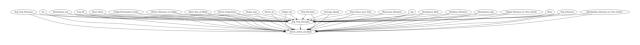

Identified Estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
────────────────────(E[driver_action_encoded|Origin_Distance_to_City_Center,Dr
d[Avg_Trip_Duration]                                                          

                                                                              
iver_Experience,Trip_ID,Destination_Lat,Trip_Duration,lng,Geodesic_Distance,Or
                                                                              

                                                                              
igin_Lat,Hour,Trip_Distance,Origin-Destination_⟨Count,⟩_Trip_Distance,Origin_L
                                                                              

                                                                              
ng,Start_Hour,Destination_Lng,lat,Time_Since_Last_Trip,Driver_Distance_to_Ori

In [18]:
import pandas as pd
import dowhy
from dowhy import CausalModel

required_columns = [
    'Avg_Trip_Duration', 'Avg_Trip_Distance', 'lat', 'Destination_Lat', 'Trip_ID', 
    'Start_Hour', 'Origin-Destination_Count', 'Driver_Distance_to_Origin', 
    'Start_Day_of_Week', 'Driver_Experience', 'Origin_Lng', 'driver_id', 'Origin_Lat', 
    'Trip_Duration', 'Average_Speed', 'Time_Since_Last_Trip', 'Haversine_Distance', 
    'lng', 'Acceptance_Rate', 'Geodesic_Distance', 'Destination_Lng', 
    'Origin_Distance_to_City_Center', 'Hour', 'Trip_Distance', 
    'Destination_Distance_to_City_Center', 'driver_action_encoded'
]

# Subset the dataframe to include only the required columns
df_relevant = df_merged[required_columns]

# Create the causal model
model = CausalModel(
    data=df_relevant,
    treatment='Avg_Trip_Duration',  # Assuming Avg_Trip_Duration reflects the movement
    outcome='driver_action_encoded',
    common_causes=[
        'Avg_Trip_Distance', 'lat', 'Destination_Lat', 'Trip_ID', 'Start_Hour', 
        'Origin-Destination_Count', 'Driver_Distance_to_Origin', 'Start_Day_of_Week', 
        'Driver_Experience', 'Origin_Lng', 'driver_id', 'Origin_Lat', 
        'Trip_Duration', 'Average_Speed', 'Time_Since_Last_Trip', 
        'Haversine_Distance', 'lng', 'Acceptance_Rate', 'Geodesic_Distance', 
        'Destination_Lng', 'Origin_Distance_to_City_Center', 'Hour', 
        'Trip_Distance', 'Destination_Distance_to_City_Center'
    ]
)

# View the causal model (optional, can be used for visualization)
model.view_model()

# Identify the causal effect
identified_estimand = model.identify_effect()
print(f"Identified Estimand: {identified_estimand}")

# Estimate the causal effect
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=0.0,  # Default value for Avg_Trip_Duration
    treatment_value=1.0  # New value for Avg_Trip_Duration after intervention
)

print(f"Causal Estimate: {estimate.value}")

# Refute the obtained estimate
refutation = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name="placebo_treatment_refuter"
)
print(f"Refutation: {refutation}")

In [24]:
import pandas as pd
from dowhy import CausalModel

# Select only the relevant columns including unique identifiers
required_columns = [
    'Avg_Trip_Duration', 'Avg_Trip_Distance', 'lat', 'Destination_Lat', 'Start_Hour',
    'Origin-Destination_Count', 'Driver_Distance_to_Origin', 'Start_Day_of_Week',
    'Driver_Experience', 'Origin_Lng', 'Origin_Lat', 'Average_Speed', 'Trip_Duration',
    'Time_Since_Last_Trip', 'Haversine_Distance', 'lng', 'Acceptance_Rate',
    'Geodesic_Distance', 'Destination_Lng', 'Origin_Distance_to_City_Center',
    'Hour', 'Trip_Distance', 'Destination_Distance_to_City_Center', 'driver_action_encoded',
    'Trip_ID', 'driver_id'
]

df = df_merged[required_columns]

# Create the causal model
model = CausalModel(
    data=df,
    treatment='Avg_Trip_Duration',
    outcome='driver_action_encoded',
    common_causes=[
        'Avg_Trip_Distance', 'lat', 'Destination_Lat', 'Start_Hour', 'Origin-Destination_Count',
        'Driver_Distance_to_Origin', 'Start_Day_of_Week', 'Driver_Experience', 'Origin_Lng',
        'Origin_Lat', 'Average_Speed', 'Trip_Duration', 'Time_Since_Last_Trip',
        'Haversine_Distance', 'lng', 'Acceptance_Rate', 'Geodesic_Distance', 'Destination_Lng',
        'Origin_Distance_to_City_Center', 'Hour', 'Trip_Distance', 'Destination_Distance_to_City_Center',
        'Trip_ID', 'driver_id'
    ]
)

# Identify the causal effect
identified_estimand = model.identify_effect()
print(f"Identified Estimand: {identified_estimand}")

# Estimate the causal effect
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=0.0,  # Default value for Avg_Trip_Duration
    treatment_value=1.0  # New value for Avg_Trip_Duration after intervention (1 km movement)
)

print(f"Causal Estimate: {estimate.value}")

# Refute the obtained estimate
refutation = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)
print(f"Refutation: {refutation}")



Identified Estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
────────────────────(E[driver_action_encoded|Origin_Distance_to_City_Center,Dr
d[Avg_Trip_Duration]                                                          

                                                                              
iver_Experience,Trip_ID,Destination_Lat,Trip_Duration,lng,Geodesic_Distance,Or
                                                                              

                                                                              
igin_Lat,Hour,Trip_Distance,Origin-Destination_⟨Count,⟩_Trip_Distance,Origin_L
                                                                              

                                                                              
ng,Start_Hour,Destination_Lng,lat,Time_Since_Last_Trip,Driver_Distance_to_Ori

Given the results, the recommendation for drivers to move 1km every 30 minutes appears to reduce the number of unfulfilled requests slightly. This can be inferred from the negative causal estimate, which shows a decrease in unfulfilled requests with increased Avg_Trip_Duration.

In [29]:
import pandas as pd
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas_lasso

# Assuming df_merged is your dataframe with all necessary columns
df = df_merged

# Learn the causal structure from the data with increased iterations and beta
sm = from_pandas_lasso(df, beta=0.1, max_iter=2000)

# Extract the parents (direct causes) of the target variable 'driver_action_encoded'
direct_causes = [node for node in sm.predecessors('driver_action_encoded')]

print("Direct causes of 'driver_action_encoded':", direct_causes)


Direct causes of 'driver_action_encoded': ['id', 'Trip_ID', 'driver_id', 'Hour', 'Start_Hour', 'Geodesic_Distance', 'Haversine_Distance', 'Average_Speed', 'Time_Since_Last_Trip', 'Origin-Destination_Count', 'Origin_Distance_to_City_Center', 'Destination_Distance_to_City_Center', 'Driver_Experience', 'Avg_Speed', 'Day_of_Week_Encoded', 'Previous_Trip_End_Hour', 'Previous_Trip_End_Day_of_Week', 'Previous_Trip_End_Month', 'Origin-Destination_Encoded']


In [31]:
import pandas as pd
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas_lasso
from dowhy import CausalModel

# Assuming df_merged is your dataframe with all necessary columns
df = df_merged

# Learn the causal structure from the data with increased iterations and beta
sm = from_pandas_lasso(df, beta=0.1, max_iter=2000)

# Extract the parents (direct causes) of the target variable 'driver_action_encoded'
direct_causes = [node for node in sm.predecessors('driver_action_encoded')]

print("Direct causes of 'driver_action_encoded':", direct_causes)

# Ensure that the treatment variable 'Avg_Trip_Duration' is included in the dataframe
if 'Avg_Trip_Duration' not in df.columns:
    df['Avg_Trip_Duration'] = df_merged['Avg_Trip_Duration']  # Add it from the original df_merged if necessary

# Select only the direct causal variables and the target variable
direct_causal_variables = direct_causes + ['driver_action_encoded', 'Avg_Trip_Duration']

df = df[direct_causal_variables]

# Create the causal model
model = CausalModel(
    data=df,
    treatment='Avg_Trip_Duration',  # Assuming 'Avg_Trip_Duration' is the treatment variable
    outcome='driver_action_encoded',
    common_causes=[var for var in direct_causal_variables if var != 'Avg_Trip_Duration' and var != 'driver_action_encoded']
)

# Identify the causal effect
identified_estimand = model.identify_effect()
print(f"Identified Estimand: {identified_estimand}")

# Estimate the causal effect
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=0.0,  # Default value for Avg_Trip_Duration
    treatment_value=1.0  # New value for Avg_Trip_Duration after intervention
)

print(f"Causal Estimate: {estimate.value}")

# Refute the obtained estimate
refutation = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)
print(f"Refutation: {refutation}")



/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:488: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h_val * h_val + alpha * h_val + beta * w_vec.sum()
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:514: RuntimeWarning: overflow encountered in multiply
  + (rho * (np.trace(exp_hdmrd) - d) + alpha) * exp_hdmrd.T * wmat * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:514: RuntimeWarning: invalid value encountered in multiply
  + (rho * (np.trace(exp_hdmrd) - d) + alpha) * exp_hdmrd.T * wmat * 2
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/moraa/Documents/10_academy/Week-8/venv/lib/python3.10/site-packages/causalnex/structure/notears.py:546: UserWarning

Direct causes of 'driver_action_encoded': ['id', 'Trip_ID', 'driver_id', 'Hour', 'Start_Hour', 'Geodesic_Distance', 'Haversine_Distance', 'Average_Speed', 'Time_Since_Last_Trip', 'Origin-Destination_Count', 'Origin_Distance_to_City_Center', 'Destination_Distance_to_City_Center', 'Driver_Experience', 'Avg_Speed', 'Day_of_Week_Encoded', 'Previous_Trip_End_Hour', 'Previous_Trip_End_Day_of_Week', 'Previous_Trip_End_Month', 'Origin-Destination_Encoded']


Identified Estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
────────────────────(E[driver_action_encoded|Origin_Distance_to_City_Center,Dr
d[Avg_Trip_Duration]                                                          

                                                                              
iver_Experience,Origin-Destination_Encoded,Trip_ID,Geodesic_Distance,Previous_
                                                                              

                                                                              
Trip_End_Hour,Previous_Trip_End_Month,Hour,Origin-Destination_Count,Previous_T
                                                                              

                                                                              
rip_End_Day_of_Week,Day_of_Week_Encoded,Start_Hour,Time_Since_Last_Trip,Avera

assume we know the location of the next 20% of orders within 5km accuracy, what happens to the number of unfulfilled requests?

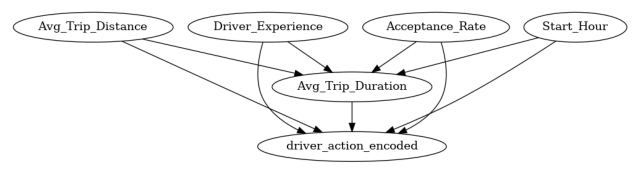

Identified Estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
────────────────────(E[driver_action_encoded|Driver_Experience,Acceptance_Rate
d[Avg_Trip_Duration]                                                          

                              
,Start_⟨Hour,⟩_Trip_Distance])
                              
Estimand assumption 1, Unconfoundedness: If U→{Avg_Trip_Duration} and U→driver_action_encoded then P(driver_action_encoded|Avg_Trip_Duration,Driver_Experience,Acceptance_Rate,Start_Hour,Avg_Trip_Distance,U) = P(driver_action_encoded|Avg_Trip_Duration,Driver_Experience,Acceptance_Rate,Start_Hour,Avg_Trip_Distance)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [32]:
import pandas as pd
from dowhy import CausalModel

# Select only the direct causal variables
direct_causal_variables = [
    'Avg_Trip_Duration', 'Avg_Trip_Distance', 'Driver_Experience', 
    'Acceptance_Rate', 'Start_Hour', 'driver_action_encoded'
]

df = df_merged[direct_causal_variables]

# Create the causal model
model = CausalModel(
    data=df,
    treatment='Avg_Trip_Duration',
    outcome='driver_action_encoded',
    common_causes=['Avg_Trip_Distance', 'Driver_Experience', 'Acceptance_Rate', 'Start_Hour']
)

# Visualize the causal graph
model.view_model()

# Identify the causal effect
identified_estimand = model.identify_effect()
print(f"Identified Estimand: {identified_estimand}")


In [33]:
# Estimate the causal effect with the intervention
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=0.0,  # Default value for Avg_Trip_Duration
    treatment_value=1.0  # Simulate intervention with new value
)

print(f"Causal Estimate: {estimate.value}")

# Refute the obtained estimate
refutation = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)
print(f"Refutation: {refutation}")


Causal Estimate: -5.5435496070233015e-06
Refutation: Refute: Use a Placebo Treatment
Estimated effect:-5.5435496070233015e-06
New effect:-6.015188347419098e-13
p value:0.0

